# Williams vs ATP Top 500
Group 18 Project Proposal by: Sandra Radic, Charlie Sushams, Clare Vu, & Alex Grinius

## Introduction

The world has already come to know and love sports based on competition fairly divided between males and females. However, not many people understand that not all sports are executed well with physicality but rather, the mentality and skills of an individual. Take tennis for example: Players who are stronger and more physically adept hold an advantage in some areas of the game, but players who are more talented skill-wise are better overall. While men and women may differ in physicality, they tend to be similar in skill capacity. Pledgesports names great examples from history of women competing against men. A prime example relevant to the background of our analysis would be from the 1970s, where Billy Jean King, the women’s champion at the time, faced off Bobby Riggs in a tennis match resulting in King winning all three sets. This match is evidence that women are capable of competing against men and that biological physical strength does not account for everything. Therefore, many outstanding female players could be serious competition to the male-dominated sport. This includes the 23-time Grand Slam champion, Serena Williams as she poses a serious threat with her sheer skill. **Using female tennis champion Serena Willliams’ statistics, specifically her height, age turned pro, best career rank to date, and number of seasons played, how would she rank when put up against the ATP top 500 male tennis players?”** Our group intends to analyze the factors that separate men's and women's sports, and use them in a classification model to predict which category (ranks from 1 - 501 players) Williams would fall under if she were to partake in a male-only tournament. 

In the world of sports, events are often divided between males and females for fairness. Therefore, female and male statistics are not usually compared in one group. However, there are many outstanding female players that could very well pose as serious competition to the male dominated sport - 23-time Grand Slam champion Serena Williams is definitely one of them. Williams is ranked number 1 in women's tennis, and started her professional career in her early teenage years, reflecting her exceptional skill. This leads to our question: How would Serena Williams rank amongst the top 500 male players? Our group intends to analyze the factors that separate men's and women's sports, and use them in a classification model to predict which category (ranks from 1 - 501 players) Williams would fall under if she were to partake in a male-only tournament. To conduct this analysis, we will be using the Player Stats for Top 500 players dataset, from  https://www.ultimatetennisstatistics.com/. We will focusing on height, number of seasons played, and the age the player began their professional career. This will allow us to examine whether physical stature serves as a male advantage or not, and otherwise compares skill level. Consequently, we will be creating categories using the "best rank" column to further sort our data and choose a new rank level for Serena. 


**TODO** mention why we chose the variables to compare that we did <br>
**TODO** explain that this IS a classification problem, and briefly touch upon the categories we create for player_level as shown in section 3 of method and results

## Methods and Results

### 1. Preliminary exploratory data analysis (reading the data)

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(scales)
library(stringr)
library(GGally)

Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'readr' was built under R version 4.0.4"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'stringr' was built under R version 4.0.5"
Warning message:
"package 'forcats' was built under R version 4.0.4"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks s

In [2]:
#read in data
player_stats_link <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_stats <- read_csv(player_stats_link)

head(player_stats)

Warning message:
"Missing column names filled in: 'X1' [1]"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)
i Use `spec()` for the full column specifications.




X1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,...,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### 2. Data Wrangling

There are a couple of steps involved in wrangling and tidying our data. As briefly mentioned in our introduction, we decided to analyze the the player's **age turned pro, height, number of seasons played, and best career rank to date** as we felt these quantitative variables would make the most impact when comparing skill levels between players. Other information in the dataset (such as the country the player is from, or whether they played with their right or left hand) was not as relevant to our question.


- Firstly, to get the age the players turned pro, we needed to subtract the year the player was born in from the year the player turned pro. In order to access the year the player was born it, we had to separate the year from the date format using R commands `as.Date` and `format`. By doing this, we successfully achieved how old the player was when they turned pro. We deemed this as an important predictor because the younger a player turned pro, the better they would generally rank as they had more experience playing in a professional league.

- We decided to use the height of the players as another predictor because male athletes tend to be taller than female athletes. In tennis, height may also serve to be an advantage because it contributes to longer wingspans, larger strides across the court, and overall more movement in a shorter amount of time.

- The number of seasons played was chosen as a predictor similarly to the reason age turned pro was. We felt that players who have played longer in the professional setting are ranked higher, so this correlation will help determine the skill level association between players and their rank. 

- Finally, we chose Best Career Rank to Date as a predictor because we felt it was more representative of a players best capability regardless of their age. The issue with comparing Billy to Bobby was their age difference at the time - Bobby was a lot older than Billy, and we want to compare our modern players at their optimum ability.

In [3]:
# select only the necessary columns

player_stats_filtered <- player_stats %>%
    select('Best Rank', 'Height', 'Seasons', 'Name', 'Turned Pro', 'Age') %>%
     drop_na()

# tidy up dataframe (ensure correct datatypes and appropriate column names)

player_stats_tidy <- player_stats_filtered %>%
    separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
# separate(col = Birthdate, into = c("Year born"), sep = "-") %>%
    mutate(Age = as.numeric(Age)) %>%
    mutate_at("Height", str_replace, " cm", "") %>%
    mutate(Height = as.numeric(Height)) %>%
    rename(Height_cm = Height, Year_turned_pro = "Turned Pro", Best_career_rank_to_date = "Best Rank")

player_stats_tidy$Best_career_rank_to_date <- gsub(" .+", "", player_stats_tidy$Best_career_rank_to_date)

#separate year from date

get_date <- as.Date(player_stats_tidy$Birthdate, "(%d-%m-%Y)")
get_year <- format(get_date, format = "%Y")

player_stats_tidy$Birthdate <- as.double(get_year)
player_stats_tidy <- mutate(player_stats_tidy, Best_career_rank_to_date = as.integer(Best_career_rank_to_date))

# create new column that lists a player's age when they turned pro

player_stats_tidy <- player_stats_tidy %>%
     mutate(Age_turned_pro = Year_turned_pro - Birthdate) %>%
    add_column(player_level = "NA") %>%
    arrange(desc(Best_career_rank_to_date))#adds new column for future categories

head(player_stats_tidy, 15)

Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro,player_level
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
183,183,8,Laurynas Grigelis,2008,28,1991,17,NA
169,183,5,Brydan Klein,2005,30,1989,16,NA
110,180,13,Peter Polansky,2007,31,1988,19,NA
99,180,10,Pedro Sousa,2007,31,1988,19,NA
98,180,7,Andrej Martin,2005,30,1989,16,NA
89,190,12,James Ward,2006,32,1987,19,NA
85,188,11,Matthias Bachinger,2005,32,1987,18,NA
84,183,7,Alessandro Giannessi,2008,29,1990,18,NA
82,183,9,James Duckworth,2010,28,1992,18,NA


**TODO** In order for us to conduct a classification analysis, we must have labelled categories to ... (on the google doc)
Our end goal is to sort Serena Williams into one of these categories based on her statistics compared with our training model.

In [4]:
# Give ranks meaningi by sorting them into categories

for (row in 1:nrow(player_stats_tidy)) {
    rank <- pull(player_stats_tidy[row, "Best_career_rank_to_date"])
    if(rank < 11) {
        player_stats_tidy[row, "player_level"] = "top" 
    } else if(rank > 10 & rank < 41) {
        player_stats_tidy[row, "player_level"] = "great"
    } else {
        player_stats_tidy[row, "player_level"] = "good"
    }
}

player_stats_tidy <- player_stats_tidy %>%
    mutate(player_level = as.factor(player_level)) %>%
    arrange(desc(player_level))
head(player_stats_tidy, 15)

Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro,player_level
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10,188,9,Pablo Carreno Busta,2011,28,1991,20,top
10,185,7,Lucas Pouille,2012,25,1994,18,top
10,190,15,Ernests Gulbis,2004,31,1988,16,top
9,178,16,Fabio Fognini,2004,32,1987,17,top
9,183,11,Roberto Bautista Agut,2005,31,1988,17,top
8,180,17,Janko Tipsarevic,2002,35,1984,18,top
8,206,14,John Isner,2007,34,1985,22,top
8,183,16,Marcos Baghdatis,2003,34,1985,18,top
7,188,19,Fernando Verdasco,2001,36,1983,18,top


Using the information found on the Serena Williams Wikipedia page, we assign values to a data_frame. This data_frame will be used to eventually predict her player level.

In [5]:
# create a dataframe for Serena Williams - currently contains junk data
serena_data <- data.frame(Best_career_rank_to_date = 1, Height_cm = 175, Seasons = 24, 
                          Name = "Serena Williams", Year_turned_pro = 1995, Age = 38, Birthdate = 1981,
                          Age_turned_pro = 14)

# serena_data sourced from: https://en.wikipedia.org/wiki/Serena_Williams

### 3. Training the Classification Model

We will begin by splitting our training and testing data. In this analysis we will be using 70% of our data for training.

In [6]:
#split the player data into training and testing sets
set.seed(2021) #making sure data is reproducible

player_stats_split <- initial_split(player_stats_tidy, prop = 0.70, strata = player_level)

player_stats_training <- training(player_stats_split)
player_stats_testing <- testing(player_stats_split)



#### 3.1 Exploratory Data Analysis

**TODO** After splitting the data into training and testing sets, we created both a visualization and a summary table of the training data, to help us better understand any potential trends or patterns in the data that will guide our analysis. Firstly, we created a scatterplot matrix to visualize the strength and direction of any correlations between the numeric variables in our dataset, if they exist. After that, we created a summary table that shows the proportions of each category, as well as the means of our variables of interest, grouped by category. This allows us to see if there are any obvious differences in the data across categories, as well as check to see if the categories are in roughly equal proportions, incase balancing is needed during analysis.

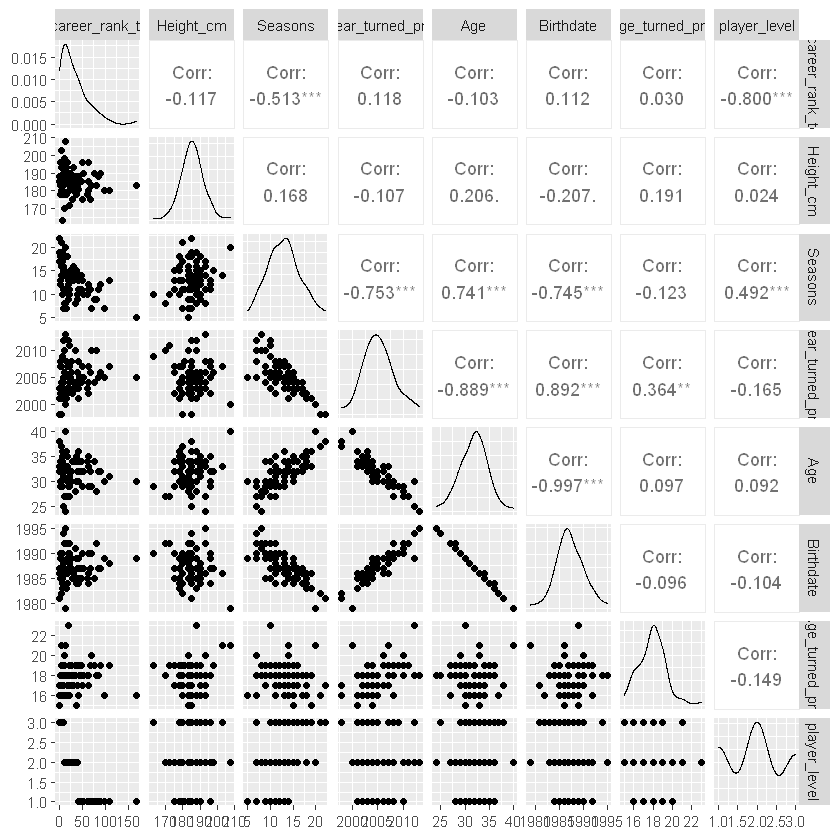

In [7]:
# options(repr.plot.width = 12, repr.plot.height = 12)
set.seed(2021)
explore_plot <- player_stats_training %>%
    select(everything(), -"Name") %>%
    mutate_all(as.numeric) %>%
    ggpairs()
explore_plot 

In [8]:
#create exploratory data frame that contains means of predictor variables
set.seed(2021)

player_stats_exploratory <- player_stats_training %>%
    group_by(player_level) %>%
    summarize(count = n(),
              percentage = n() / nrow(player_stats_training) * 100,
              mean_height_cm = mean(Height_cm, na.rm = TRUE),
              mean_number_pro_seasons = mean(Seasons, na.rm = TRUE),
              mean_age_turned_pro = mean(Age_turned_pro, na.rm = TRUE))

player_stats_exploratory

player_level,count,percentage,mean_height_cm,mean_number_pro_seasons,mean_age_turned_pro
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
good,22,30.13699,184.5909,10.95455,18.04545
great,32,43.83562,186.4062,12.68750,18.03125
top,19,26.02740,184.9474,15.68421,17.47368


#### 3.2 Visualizing our predictor variables

**TODO** Based upon our scatterplot matrix, the two variables with the strongest correlation to best career rank are height and number of professional seasons played. Using this knowledge, we created a scatterplot that plots height vs number of professional seasons played, coloured by player level. Due to the different scales of the variables, scaling and centering was performed before plotting.

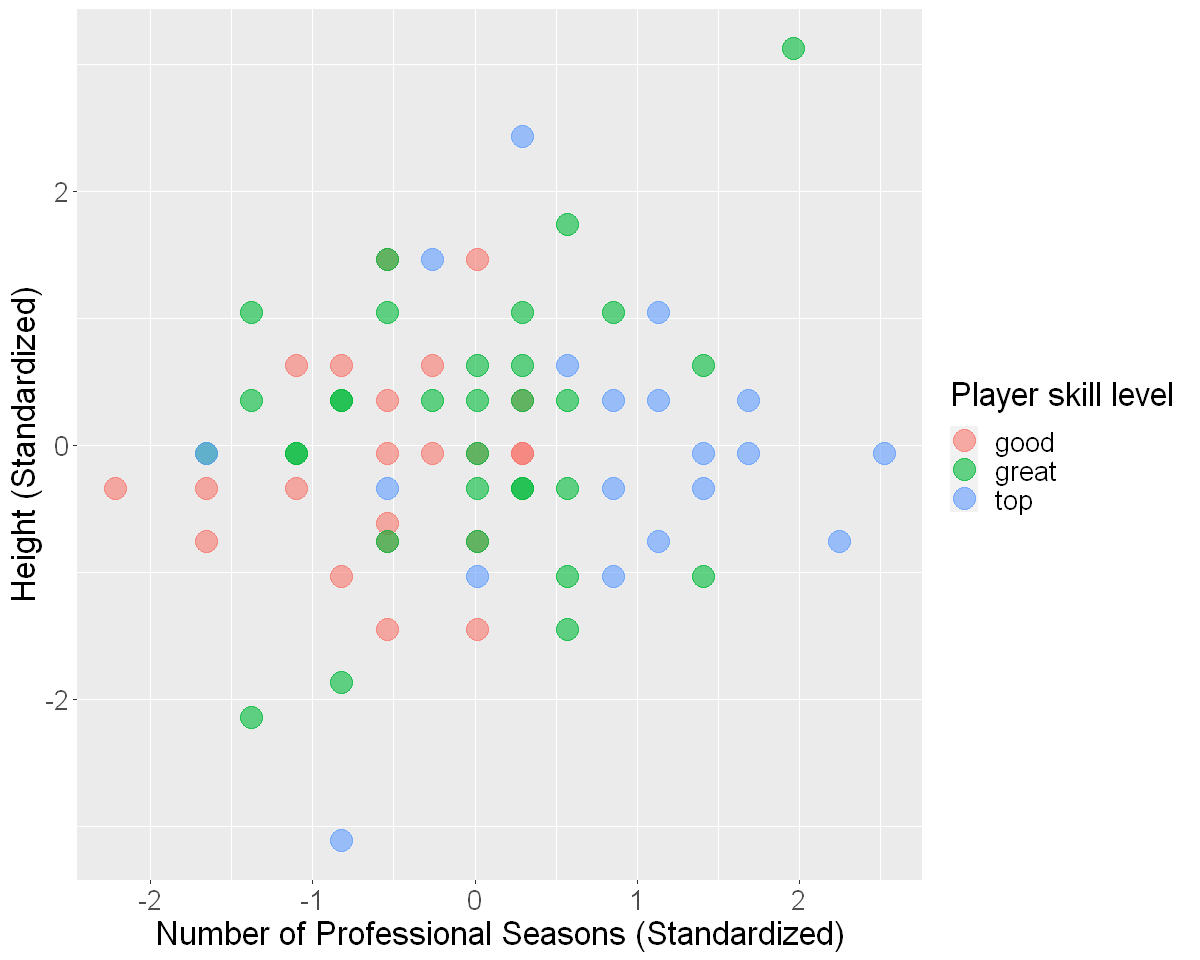

In [9]:
seas_height_stats <- player_stats_training %>%
    select(Seasons, Height_cm, player_level)

seas_height_recipe <- recipe(player_level ~ ., data = seas_height_stats) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

season_height_scaled <- bake(seas_height_recipe, seas_height_stats)

options(repr.plot.width = 10, repr.plot.height = 8)
seas_height_plot <- season_height_scaled %>%
    ggplot(aes(x = Seasons, y = Height_cm, colour = player_level)) +
    geom_point(alpha = 0.6, size = 6) +
    labs(x = "Number of Professional Seasons (Standardized)",
         y = "Height (Standardized)",
         colour = "Player skill level") +
    theme(text = element_text(size = 20))

seas_height_plot

**TODO** Based on our independent variables compared wiht the best professional career rank, we predict 

(REVIEW) that she will be in the top category. This is because of her high number of seasons (level goes up with number of seasons) and young age turned pro (as gae goes down, level goes up).

In [10]:
set.seed(2021)
# center and scale data in recipe 
player_recipe <- recipe(player_level ~ + Height_cm + Seasons, data = player_stats_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())
player_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### 4. Cross-Validation

To begin our training with currently unknown value k, we use a 10-fold cross-validation.

In [11]:
set.seed(2021)
player_vfold <- vfold_cv(player_stats_training, v = 10, strata = player_level)

#### 4.1 Tuning our data

We tune our data because we don't know which k-value to use yet. This process will help us visualize and decide which k-value provides the highest accuracy in the context of our model.

In [12]:
set.seed(2021)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

player_results <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = player_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- player_results %>%
    filter(.metric == "accuracy")
head(accuracies)

Warning message:
"package 'rlang' was built under R version 4.0.5"
Warning message:
"package 'vctrs' was built under R version 4.0.5"
Warning message:
"package 'kknn' was built under R version 4.0.5"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4000000,10,0.05415467,Preprocessor1_Model01
3,accuracy,multiclass,0.4634921,10,0.06027103,Preprocessor1_Model02
5,accuracy,multiclass,0.4666667,10,0.07339828,Preprocessor1_Model03
7,accuracy,multiclass,0.4833333,10,0.07499848,Preprocessor1_Model04
9,accuracy,multiclass,0.4801587,10,0.05855173,Preprocessor1_Model05
11,accuracy,multiclass,0.4849206,10,0.05460833,Preprocessor1_Model06


To better understand what our accuracy table means, we visualize it in a line plot:

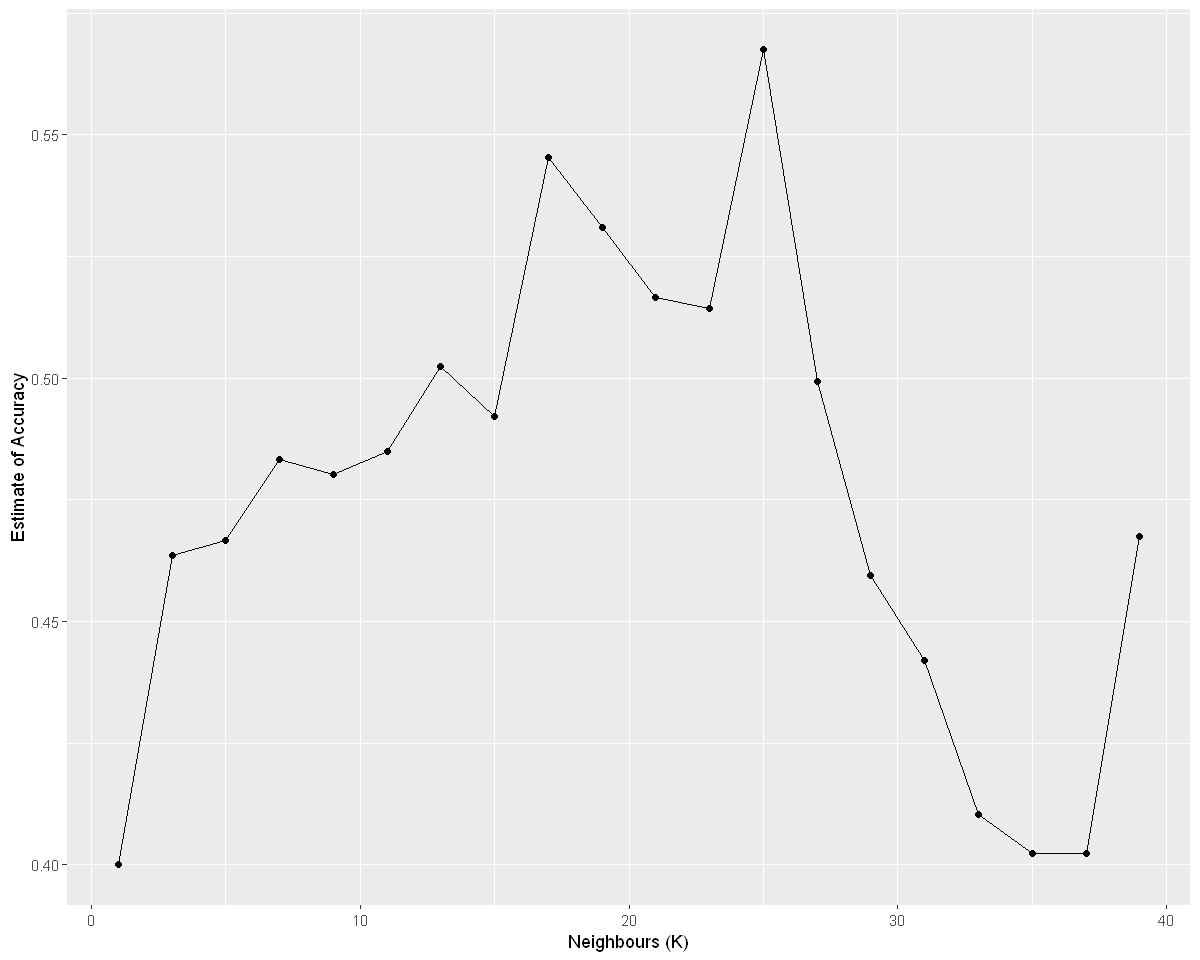

In [13]:
set.seed(2021)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                xlab("Neighbours (K)") +
                ylab("Estimate of Accuracy")
cross_val_plot

**TODO** k = 19. This value for K is selected because it provides roughly optimal accuracy (53% vs 57%) and changing the value to a nearby number of neighbours doesn't significantly change the accuracy, which makes our model more reliable in the presence of uncertainty. Conversely, choosing either 17 (55%) or 25 (57%) yields a higher accuracy, but changing k by a small amount leads to a significant change in accuracy, thus making the model less reliable.

**(note from sandra: shouldn't it be k = 15 because of the highest peak?)**

**TODO** explain test prediction process below

**TODO** In this next step, we retrain our model using our selected k value and consequently measure its' accuracy against test predictions. In our table below, it shows  that our accuracy estimate is of about 0.56 or 56%.

In [14]:
set.seed(2021)

player_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) %>%
    set_engine("kknn") %>%
    set_mode("classification")

player_fit <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(player_tuned_spec) %>%
    fit(data = player_stats_training)

player_test_predictions <- predict(player_fit, player_stats_testing) %>%
    bind_cols(player_stats_testing)

model_accuracy <- player_test_predictions %>%
    metrics(truth = player_level, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

model_accuracy



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5588235


Consequently, to further visualize this percentage we create a confusion matrix (named "confusion") to see how well our tests have been predicting. According to our produced table, our model succeeded in predicting 17 out of 31 categories (also 55%). 

In [15]:
confusion <- player_test_predictions %>% 
      conf_mat(truth = player_level, estimate = .pred_class)

confusion

          Truth
Prediction good great top
     good     7     1   0
     great    3    11   8
     top      0     3   1

### 5. Training Serena

Next, it is time to introduce our Serena data to the model. In the following cell, we make a prediction for her player level pa

In [16]:
#predict Player Level for Serena Williams
set.seed(2021)
serena_prediction <- predict(player_fit, serena_data) %>%
bind_cols(serena_data)

serena_prediction <- serena_prediction %>%
    rename(player_level = .pred_class)
serena_prediction

player_level,Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
top,1,175,24,Serena Williams,1995,38,1981,14


As we can see, Serena's history of seasons played, young age turned pro (14) and best career rank contributed to her being classified as a top player.

Our next steps involve standardizing Serena's data and appending it to our men's tennis dataset to see how well she would place when being measured in the men's world of tennis. Then, we standardize it to match the format of the rest of our dataset.

In [31]:
#combine serena prediction with rows of the training dataset
player_training_with_serena <- rbind(player_stats_training, serena_prediction)

#create recipe to help with standardization process
serena_recipe <- recipe(player_level ~ + Height_cm + Seasons, data = player_training_with_serena) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors()) %>%
   prep()

serena_standardized <- bake(serena_recipe, player_training_with_serena) %>%
     bind_cols(player_training_with_serena$Name)

serena_standardized <- serena_standardized %>%
    rename(Name = "...4") %>%
    filter(Name == "Serena Williams") # ..4 is the name of Serena 
serena_standardized

New names:
* NA -> ...4



Height_cm,Seasons,player_level,Name
<dbl>,<dbl>,<fct>,<chr>
-1.42267,2.877747,top,Serena Williams


Even when standardized, Serena appears to be a top player when put up against our model, suggesting that height may not be our biggest factor to compare the skills of tennis players.

**TODO** Not sure what's going on with this graph but i didn't want to mess it up (it doesn't run right now on my end)

*insert description about the graph once fixed*


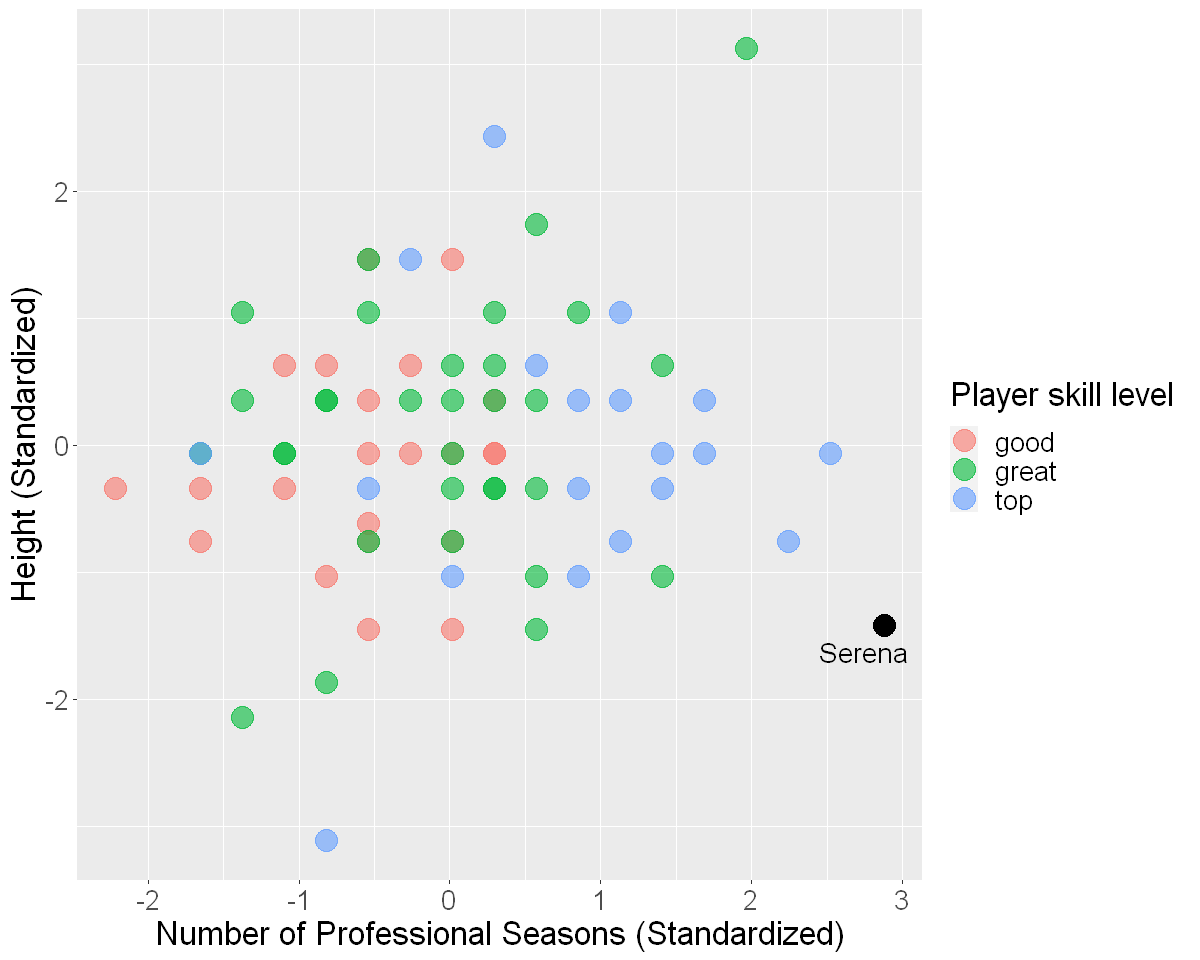

In [29]:
#graph location of serena point
set.seed(2021)

options(repr.plot.width = 10, repr.plot.height = 8)
seas_height_plot +
    geom_point(aes(x = 2.877747, y = -1.42267), colour = "black", size = 6) +
    annotate("text", x = 2.75, y = -1.63, label = "Serena", size = 6)

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


Assumptions we had to make:
- all players were at their peak performance
- tennis ability is static and consistent across games

Future questions
- its not relaly possible to compare serena directly because her stats are from playing against a whole other database of female players, whereas the mens data set was consistently male-v-male with each other  
- with time and money, we could arrange a co-ed tournament to help fix this issue and directly analyze
- even with these suggestions, our accuracy level was pretty low and barely passing, indicating that tennis is simply hard to measure. Every player is individual in their own way, and there are so many little intricacies to account for beyond the data set (such as mental health on playday, the weather, what kind of court they're playing on, etc). Especially since it is an individual sport.


## References

found in google doc, but not cited lmao